## Project Overview
This analysis explores the relationship between Yelp restaurant success (review count and average star rating) and user engagement metrics (reviews, tips, and check-ins). We also examine sentiment and time-based engagement patterns to understand long-term business success.


## Key Hypotheses
1. Higher user engagement correlates with higher review counts and ratings.
2. Positive sentiment contributes to higher ratings and review volume.
3. Consistent engagement over time is associated with sustained success.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sqlite3 

import folium #for ploting maps
from geopy.geocoders import Nominatim #langitude-longitude plotation
from matplotlib.colors import LinearSegmentedColormap #for custom colors

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Database Creation

In [2]:
conn = sqlite3.connect('yelp.db')

In [3]:
query = '''SELECT name FROM sqlite_master WHERE type = 'table';'''
tables = pd.read_sql(query, conn) # stored names of table in 'tables' tuple
tables

,name
0,business
1,checkin
2,review
3,tip
4,user


In [4]:
pd.set_option('display.max_columns', None)

In [ ]:
for table in tables['name']:
    print(f"\nTable: {table}")
    display(pd.read_sql(f"SELECT * FROM {table} LIMIT 5", conn))
    print('-'*50)

#can't show sample due to "YELP DATASET TERMS OF USE"

## Data Analysis

In [6]:
query = '''SELECT COUNT(*) total_business FROM business'''
pd.read_sql(query, conn)

,total_business
0,150346


In [7]:
query = '''SELECT business_id, review_count FROM business WHERE LOWER(categories) LIKE '%restaurant%' AND is_open = 1;'''
business_id = pd.read_sql(query, conn)
business_id.shape

(35004, 2)

#### Ratings (avg stars) vs user engagement

In [8]:
# Finding descriptive stats for review_count and star ratings for businesses

query = f''' SELECT MIN(review_count) AS min_review_count,
       MAX(review_count) AS max_review_count,
       AVG(review_count) AS avg_review_count,
       (SELECT review_count FROM business ORDER BY review_count LIMIT 1 OFFSET (SELECT COUNT(*) FROM business)/2) AS median_review_count,
    

        MIN(stars) AS min_stars,
       MAX(stars) AS max_stars,
       AVG(stars) AS avg_stars,
       (SELECT stars FROM business ORDER BY stars LIMIT 1 OFFSET (SELECT COUNT(*) FROM business)/2) AS median_stars
       
FROM business
WHERE business_id IN {tuple(business_id['business_id'])};
'''

pd.read_sql(query, conn).transpose()

,0
min_review_count,5.000000
max_review_count,7568.000000
avg_review_count,104.097789
median_review_count,15.000000
min_stars,1.000000
max_stars,5.000000
avg_stars,3.523969
median_stars,3.500000


In [9]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr # 1.5 gives reasonal margin
    upper = q3 + 1.5 * iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [10]:
business_id = remove_outliers(business_id, 'review_count')

In [11]:
business_id.shape

(31537, 2)

In [12]:
query = f''' SELECT MIN(review_count) AS min_review_count,
       MAX(review_count) AS max_review_count,
       AVG(review_count) AS avg_review_count,
       (SELECT review_count FROM business ORDER BY review_count LIMIT 1 OFFSET (SELECT COUNT(*) FROM business)/2) AS median_review_count,
    

        MIN(stars) AS min_stars,
       MAX(stars) AS max_stars,
       AVG(stars) AS avg_stars,
       (SELECT stars FROM business ORDER BY stars LIMIT 1 OFFSET (SELECT COUNT(*) FROM business)/2) AS median_stars
       
FROM business
WHERE business_id IN {tuple(business_id['business_id'])};
'''

pd.read_sql(query, conn).transpose()

,0
min_review_count,5.000000
max_review_count,248.000000
avg_review_count,55.975426
median_review_count,15.000000
min_stars,1.000000
max_stars,5.000000
avg_stars,3.477281
median_stars,3.500000


In [13]:
# Which restaurants have highest number of reviews?

query = f'''SELECT name, SUM(review_count) AS total_reviews, AVG(stars) AS avg_rating
            FROM business
            WHERE business_id In {tuple(business_id['business_id'])}
            GROUP BY 1
            ORDER BY 2 DESC
            LIMIT 10;
'''
pd.read_sql(query, conn)

,name,total_reviews,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7687,3.377419
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5744,2.514706


In [14]:
# Which restaurants have highest rating?

query = f'''SELECT name, SUM(review_count) AS total_reviews, AVG(stars) AS avg_rating
            FROM business
            WHERE business_id In {tuple(business_id['business_id'])}
            GROUP BY 1
            ORDER BY 3 DESC
            LIMIT 10;
'''
pd.read_sql(query, conn)

,name,total_reviews,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


In [15]:
# Do restaurants with higher engagement tend to have higher ratings?

query = ''' SELECT business_id, 
            SUM(length(date) - length(replace(date,',','')) + 1) as checkin_count
            FROM checkin
            GROUP BY 1
'''
pd.read_sql(query, conn)

,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


In [16]:
query = ''' SELECT business_id, 
            COUNT(business_id) as tip_count
            FROM tip
            GROUP BY 1
            ORDER BY 2
'''
pd.read_sql(query, conn)

,business_id,tip_count
0,--30_8IhuyMHbSOcNWd6DQ,1
1,--9osgUCSDUWUkoTLdvYhQ,1
2,--FWWsIwxRwuw9vIMImcQg,1
3,--ZWv8kGlM2YL58uKhGJDg,1
4,--_9CAxgfXZmoFdNIRrhHA,1
...,...,...
106188,Eb1XmmLWyt_way5NNZ7-Pw,826
106189,ytynqOUb3hjKeJfRj5Tshw,827
106190,_ab50qdWOk0DdB6XOrBitw,932
106191,-QI8Qi8XWH3D8y8ethnajA,1011


In [17]:
query = f''' 
 SELECT final.avg_rating AS rating,
        AVG(final.review_count) AS avg_review_count,
        AVG(final.checkin_count) AS avg_checkin_count,
        AVG(final.tip_count) AS avg_tip_count
 FROM
            (SELECT  b.business_id as business_id,
                    SUM(b.review_count) AS review_count,
                    AVG(b.stars) AS avg_rating,
                    SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date,',','')) + 1) as checkin_count,
                    SUM(tip.tip_count) AS tip_count
            FROM business b
            LEFT JOIN checkin cc
                ON b.business_id = cc.business_id
            LEFT JOIN 
                (SELECT business_id,  COUNT(business_id) as tip_count FROM tip GROUP BY 1 ORDER BY 2) AS tip
                ON tip.business_id = b.business_id
            WHERE b.business_id IN {tuple(business_id['business_id'])}
            GROUP BY b.business_id) AS final
            
 GROUP BY final.avg_rating
'''
review_count_df = pd.read_sql(query, conn)
review_count_df

,rating,avg_review_count,avg_checkin_count,avg_tip_count
0,1.0,14.365079,17.518072,2.781513
1,1.5,24.358459,34.480969,3.884654
2,2.0,27.759629,52.386515,4.581058
3,2.5,36.631037,79.349429,6.325225
4,3.0,48.054998,105.970405,8.301950
5,3.5,63.730125,125.781702,10.320786
6,4.0,73.136954,127.139075,11.329362
7,4.5,65.282554,86.177605,8.995201
8,5.0,31.127979,27.545113,4.269082


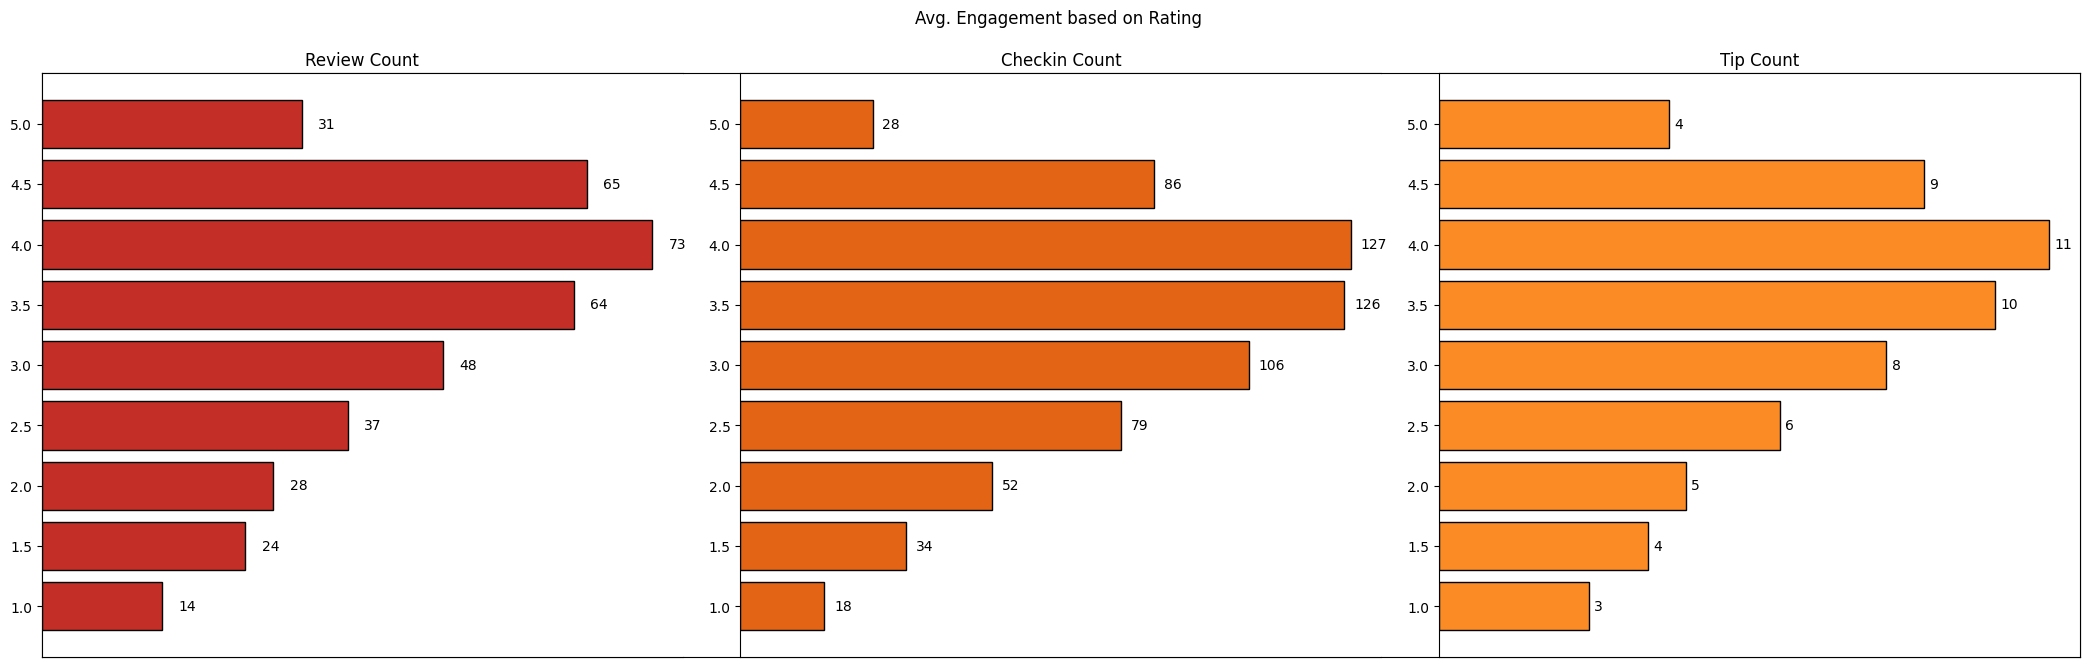

In [18]:
# ploting bar graph using sub_plot for better understanding of the matrix ,#ff611d,#e32929,#813531

plt.figure(figsize = (21,7))
plt.title('Avg. Engagement based on Rating \n \n') # "\n" for avoid overlaping

plt.xticks([])
plt.yticks([]) # removing axises for cleaner look

plt.subplot(1,3,1)
plt.title('Review Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_review_count'], edgecolor = 'k', color = '#c32f27')
plt.gca().spines['right'].set_visible(False) # hiding right boarder
for i, value in enumerate(review_count_df['avg_review_count']): # for annotating each bar
    plt.text(value + 2, i, f'{round(value)}', va = 'center', color = 'k')
plt.xticks([]) # hiding x-axis for clean visual

plt.subplot(1,3,2)
plt.title('Checkin Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_checkin_count'], edgecolor = 'k', color = '#e36414')
plt.gca().spines['right'].set_visible(False) # hiding right boarder
for i, value in enumerate(review_count_df['avg_checkin_count']): # for annotating each bar
    plt.text(value + 2, i, f'{round(value)}', va = 'center', color = 'k')
plt.xticks([]) # hiding x-axis for clean visual

plt.subplot(1,3,3)
plt.title('Tip Count')
plt.barh(review_count_df['rating'].astype('str'), review_count_df['avg_tip_count'], edgecolor = 'k', color = '#fa8b25')
#plt.gca().spines['right'].set_visible(False) # hiding right boarder
for i, value in enumerate(review_count_df['avg_tip_count']): # for annotating each bar
    plt.text(value + 0.1, i, f'{round(value)}', va = 'center', color = 'k')
plt.xticks([]) # hiding x-axis for clean visual

plt.tight_layout() #adjusts spacing so nothing overlap

plt.show()

**Insights:**
- Businesses rated around 4-Stars might be the 'most popular' (users engage more) - good service, but still accessible/ affordable.
- **Very high-rated (> 4)** may be less frequently visited (due to expensive, specialized or niche services, lower customer volume but higher satisfaction). So, **engagement drops but quality remains high**.

#### correlation between engagement parameters

In [19]:
# Finding correlation between the number of reviews, tips, and check-ins for a business

query = f'''
SELECT  b.business_id as business_id,
                    SUM(b.review_count) AS review_count,
                    AVG(b.stars) AS avg_rating,
                    SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date,',','')) + 1) as checkin_count,
                    SUM(tip.tip_count) AS tip_count,
                    CASE WHEN b.stars >=3.5 THEN 'High-Rated'
                        ELSE 'Low-Rated' END AS category
            FROM business b
            LEFT JOIN checkin cc
                ON b.business_id = cc.business_id
            LEFT JOIN 
                (SELECT business_id,  COUNT(business_id) as tip_count FROM tip GROUP BY 1 ORDER BY 2) AS tip
                ON tip.business_id = b.business_id
            WHERE b.business_id IN {tuple(business_id['business_id'])}
            GROUP BY b.business_id'''

engagement_df = pd.read_sql(query, conn).dropna() # to drop the rows if they didn't receive tip (or any other column with null)
engagement_df

,business_id,review_count,avg_rating,checkin_count,tip_count,category
0,---kPU91CF4Lq2-WlRu9Lw,24,4.5,11.0,4.0,High-Rated
1,--0iUa4sNDFiZFrAdIWhZQ,14,3.0,10.0,6.0,Low-Rated
2,--epgcb7xHGuJ-4PUeSLAw,34,3.0,118.0,6.0,Low-Rated
4,--lqIzK-ZVTtgwiQM63XgQ,15,2.0,21.0,2.0,Low-Rated
5,-09Oc2D14vRnmirPh0vlXw,135,3.0,500.0,25.0,Low-Rated
...,...,...,...,...,...,...
31530,zzIF9qp2UoHN48EeZH_IDg,19,3.0,6.0,5.0,Low-Rated
31532,zzbZtgPYZS8sTIWQH6DwEw,86,3.0,292.0,17.0,Low-Rated
31533,zziDpuuJw-Km1J4BaGpBKA,6,3.5,20.0,2.0,High-Rated
31534,zzjFdJwXuxBOGe9JeY_EMw,47,4.0,27.0,2.0,High-Rated


In [20]:
engagement_df[['review_count', 'checkin_count', 'tip_count']].corr()

,review_count,checkin_count,tip_count
review_count,1.000000,0.626884,0.766321
checkin_count,0.626884,1.000000,0.772088
tip_count,0.766321,0.772088,1.000000


**Note :** In correlation, if the value (correlation coefficient) is >0. It shows positive correlation.

Possible Insights: High correlation between REVIEWS & CHECK-INs, showing strong user engagement.

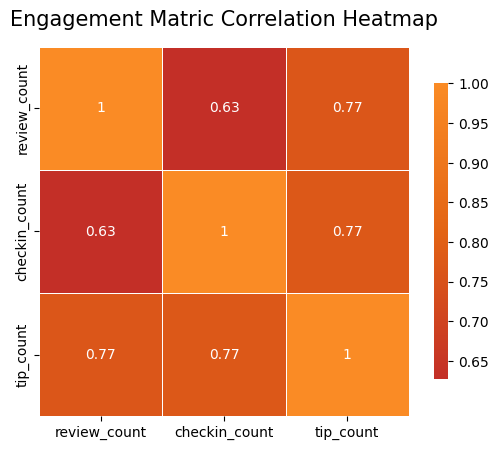

In [21]:
# creating heatmap of correlation

colors = ['#c32f27', '#e36414', '#fa8b25' ]

custom_cmap = LinearSegmentedColormap.from_list('mycmap', colors) # for custom colormap from the colors

sns.heatmap(engagement_df[['review_count', 'checkin_count', 'tip_count']].corr(), cmap = custom_cmap,
            annot = True, linewidths = 0.5, linecolor= 'white', square= True, cbar_kws= {'shrink':0.8} )

plt.title('Engagement Matric Correlation Heatmap', fontsize = 15, pad = 15)
plt.show()

In [22]:
# Finding any difference in the user engagement (reviews, tips, and check-ins) between high-rated and low-rated businesses?
engagement_df.groupby('category')[['review_count', 'tip_count', 'checkin_count']].mean() # considering "mean" to understand How engaged users are with each individual business in that group

,review_count,tip_count,checkin_count
category,,,
High-Rated,72.291062,10.162766,122.066641
Low-Rated,42.123420,6.541689,88.880828


**Insights:** High-rated restaurants have higher user engagement across reviews, tips, and check-ins compared to low-rated ones, indicating that **stronger customer interaction** is associated with better restaurant performance.

### States with high successful restaurants

In [23]:
# function to calculate the success score (quality * quantity) based on the avg rating (quality) and total review count (quantity)

def calculate_success_metric(df):
    success_score = []
    for index, row in df.iterrows():
        score = row['avg_rating'] * np.log(row['review_count'] + 1) # log for smoothing the effect & '+1' for avoiding error of Zero rating
        success_score.append(score)
    return success_score

In [24]:
# How do the success metrics (review_count or avg_rating) of restaurants vary across different states and cities?
query = f'''
            SELECT city, state, latitude, longitude, AVG(stars) AS avg_rating, SUM(review_count) AS review_count,
            COUNT(*) AS restaurant_count
            FROM business
            WHERE business_id IN {tuple(business_id['business_id'])}
            GROUP BY 1,2
            ORDER BY 6 DESC
            LIMIT 10;
            '''
city_df = pd.read_sql(query, conn)

city_df['success_score'] = calculate_success_metric(city_df)

In [25]:
city_df

,city,state,latitude,longitude,avg_rating,review_count,restaurant_count,success_score
0,Philadelphia,PA,39.955505,-75.155564,3.532156,175487,3001,42.651934
1,Tampa,FL,27.890814,-82.502346,3.571429,104376,1715,41.270588
2,Indianapolis,IN,39.637133,-86.127217,3.412111,92639,1701,39.022521
3,Tucson,AZ,32.338572,-111.010760,3.386187,91613,1419,38.688341
4,Nashville,TN,36.208102,-86.768170,3.493590,87070,1404,39.737764
5,New Orleans,LA,29.963974,-90.042604,3.693676,69239,1012,41.167252
6,Saint Louis,MO,38.583223,-90.407187,3.414303,51490,811,37.042331
7,Reno,NV,39.476518,-119.784037,3.479626,48393,589,37.535187
8,Edmonton,AB,53.436403,-113.604288,3.509379,45916,1546,37.671748
9,Boise,ID,43.611192,-116.206275,3.558824,36104,561,37.346958


In [26]:
# Created a base map
m = folium.Map(location=[city_df['latitude'].mean(), city_df ['longitude'].mean()], zoom_start=4)

# Defined a color scale
color_scale = folium.LinearColormap(colors = ['green', 'yellow', '#E54F29'], 
                                    vmin=city_df['success_score'].min(),
                                    vmax=city_df['success_score'].max())

#Add markers to the map
for index, row in city_df.iterrows():
    folium.CircleMarker(
        location= [row['latitude'], row['longitude']],
        radius=5,
        color=color_scale(row['success_score']),
        fill=True,
        fill_color=color_scale(row['success_score']),
        fill_opacity=0.7,
        popup=f"Success Score: {row['success_score']}"
    ).add_to(m)

# Add color scale to the map
m.add_child(color_scale)

**Insights:** Cities near water bodies or coastal areas (Philadelphia, Tampa, New Orleans) show **higher restaurant success scores** and review activity, suggesting that **proximity to water may positively influence** restaurant popularity and customer engagement.

### Impact of seasonality on success

In [27]:
# Are there any patterns in user engagement over time for successful businesses compared to less successful ones?
# Are there any seasonal trends in the user engagement for restaurants?

query = f''' SELECT review.month_year, review.review_count, tip.tip_count 
            FROM 
                ( SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) as review_count
                    FROM review
                    WHERE business_id IN {tuple(business_id['business_id'])} AND stars >= 3.5
                    GROUP BY 1
                    ORDER BY 1 ) AS review
            JOIN
                ( SELECT strftime('%m-%Y', tip.date) AS month_year, COUNT(*) as tip_count
                    FROM tip
                     JOIN business b
                    ON b.business_id = tip.business_id
                    WHERE tip.business_id IN {tuple(business_id['business_id'])} AND b.stars >= 3.5
                    GROUP BY 1
                    ORDER BY 1 ) AS tip
            ON review.month_year = tip.month_year;
''' # joining business table for stars (to compare i.e. >= 3.5)
high_rated_engagement = pd.read_sql(query, conn)


query1 = f''' SELECT review.month_year, review.review_count, tip.tip_count 
            FROM 
                ( SELECT strftime('%m-%Y', date) AS month_year, COUNT(*) as review_count
                    FROM review
                    WHERE business_id IN {tuple(business_id['business_id'])} AND stars < 3.5
                    GROUP BY 1
                    ORDER BY 1 ) AS review
            JOIN
                ( SELECT strftime('%m-%Y', tip.date) AS month_year, COUNT(*) as tip_count
                    FROM tip
                     JOIN business b 
                    ON b.business_id = tip.business_id
                    WHERE tip.business_id IN {tuple(business_id['business_id'])} AND b.stars < 3.5
                    GROUP BY 1
                    ORDER BY 1 ) AS tip
            ON review.month_year = tip.month_year;
''' 
low_rated_engagement = pd.read_sql(query1, conn)

In [28]:
high_rated_engagement

,month_year,review_count,tip_count
0,01-2010,1218,79
1,01-2011,2171,621
2,01-2012,3086,1321
3,01-2013,3801,1230
4,01-2014,4973,1357
...,...,...,...
149,12-2017,10161,1477
150,12-2018,12870,1163
151,12-2019,13756,1161
152,12-2020,11294,937


In [29]:
low_rated_engagement

,month_year,review_count,tip_count
0,01-2010,613,25
1,01-2011,1103,297
2,01-2012,1748,538
3,01-2013,2196,548
4,01-2014,2769,607
...,...,...,...
149,12-2017,5970,441
150,12-2018,7574,338
151,12-2019,7591,275
152,12-2020,5014,148


In [30]:
query = f''' SELECT strftime('%m-%Y', date) AS month_year, AVG(stars) AS avg_rating
            FROM review
            WHERE business_id IN {tuple(business_id['business_id'])}
            GROUP BY 1
            ORDER BY 1;
'''

time_rating = pd.read_sql(query, conn)
time_rating

,month_year,avg_rating
0,01-2006,4.000000
1,01-2007,3.897436
2,01-2008,3.603960
3,01-2009,3.690661
4,01-2010,3.724194
...,...,...
198,12-2017,3.613415
199,12-2018,3.608687
200,12-2019,3.665246
201,12-2020,3.833701


In [31]:
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace=True)  # sorting in ASC so the ploting could be done
time_rating = time_rating[time_rating['month_year'] > '2017']

high_rated_engagement['month_year'] = pd.to_datetime(high_rated_engagement['month_year'])
high_rated_engagement.sort_values('month_year', inplace=True)
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year'] > '2017']

low_rated_engagement['month_year'] = pd.to_datetime(low_rated_engagement['month_year'])
low_rated_engagement.sort_values('month_year', inplace=True)
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year'] > '2017']

In [32]:
high_rated_engagement['avg_rating'] = time_rating['avg_rating'].values # for having same number of values

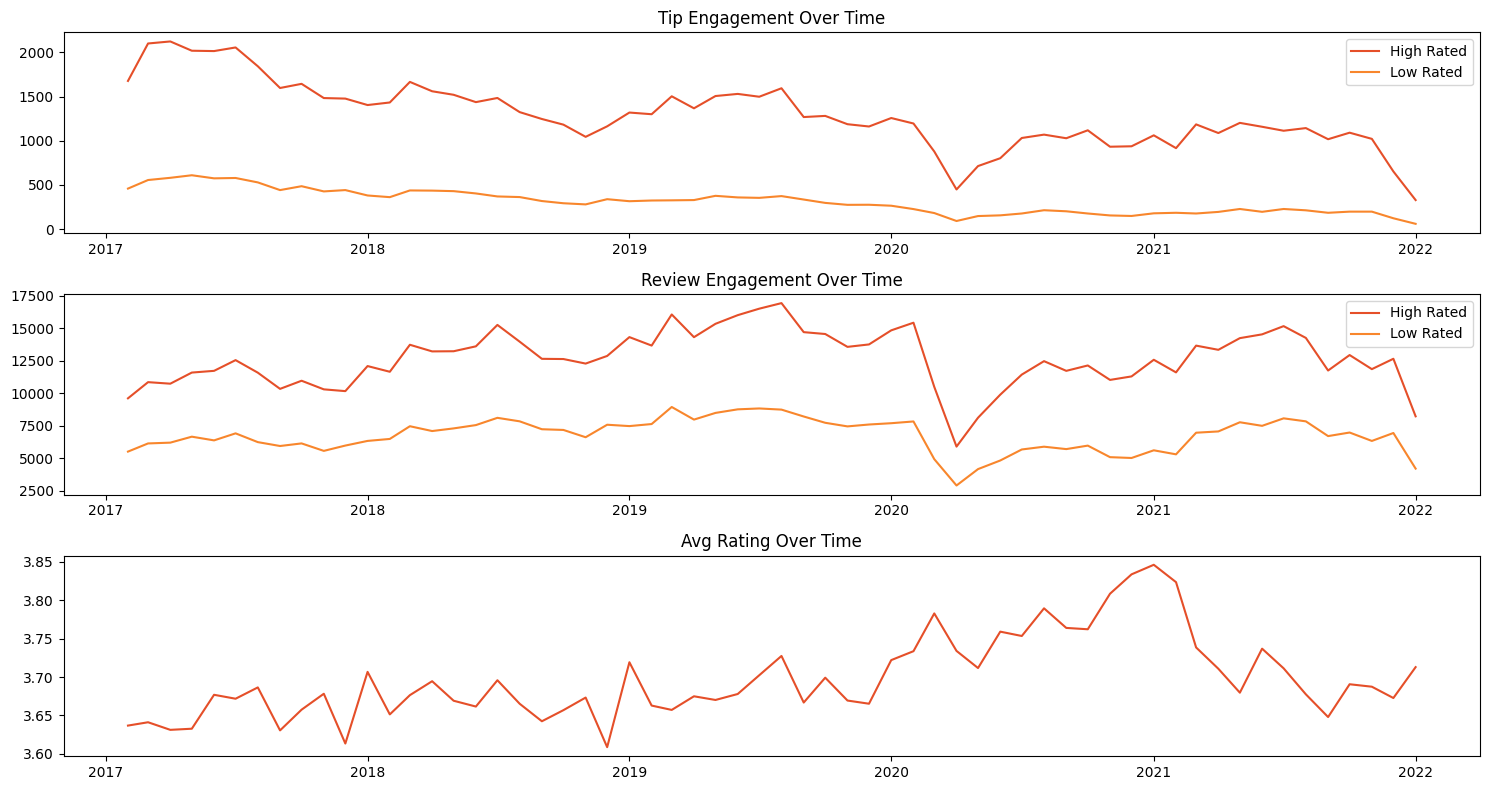

In [33]:
plt.figure(figsize= (15,8))

plt.subplot(3,1,1)
plt.title('Tip Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label = 'High Rated', color = '#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['tip_count'], label = 'Low Rated', color = '#F8862C')
plt.legend()

plt.subplot(3,1,2)
plt.title('Review Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['review_count'], label = 'High Rated', color = '#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['review_count'], label = 'Low Rated', color = '#F8862C')
plt.legend()

plt.subplot(3,1,3)
plt.title('Avg Rating Over Time')
plt.plot(time_rating['month_year'], time_rating['avg_rating'], color = '#E54F29')

plt.tight_layout()
plt.show()

Here, at the `starting and ending` of the year, **seasonaliity is on its peak**.

'Resid' means "residual or random noise". It contains unexplained fluctuations.

### Impact of Review Engagement on Success

In [34]:
# How does the sentiments of reviews and tips (useful, funny, cool) correlate with the success metrics of restraunts?

query = f"""SELECT b.business_id, AVG(b.stars) as avg_rating, 
                    SUM(b.review_count) as review_count,
                    SUM(s.useful_count) as useful_count, 
                    SUM(s.funny_count) as funny_count,
                    SUM(s.cool_count) as cool_count
            FROM
                (SELECT business_id,
                    SUM(useful) as useful_count,
                    SUM(funny) as funny_count,
                    SUM(cool) as cool_count
                 FROM review
                 GROUP BY business_id) as s
            JOIN business as b 
            ON b.business_id = s.business_id
            WHERE b.business_id IN {tuple (business_id['business_id'])}
            GROUP BY b.business_id
            ORDER BY review_count"""

sentiment_df = pd.read_sql(query, conn)
sentiment_df

,business_id,avg_rating,review_count,useful_count,funny_count,cool_count
0,-2CPhK6ik9ZBgFX_F-dkxQ,2.0,5,3,5,3
1,-3ArWZfDjfab8qVHf3WVtg,4.0,5,18,3,2
2,-4lNMmoW7gRxkH0c2dfXfA,4.0,5,1,0,0
3,-7UDKbg_8TL4LVuYR6Ooyw,3.0,5,3,0,2
4,-AzaeuPwxqFO4SMSKjbuCw,3.0,5,5,0,0
...,...,...,...,...,...,...
31532,nLyyTrxpEOdmNl9P95zXGA,4.0,248,185,50,117
31533,s3ZR7G5l-YN5fqms8vRSRw,4.0,248,107,34,75
31534,vxWjLZMn3uzDQyOjAdwq3w,3.5,248,189,55,110
31535,wPQWqLxY6t3-yRBNPPAmkQ,4.0,248,157,28,93


In [35]:
sentiment_df = remove_outliers(sentiment_df, 'review_count')
sentiment_df = remove_outliers(sentiment_df, 'useful_count')
sentiment_df = remove_outliers(sentiment_df, 'funny_count')
sentiment_df = remove_outliers(sentiment_df, 'cool_count')

In [36]:
sentiment_df['success_score'] = calculate_success_metric(sentiment_df)

In [37]:
corr1 = sentiment_df.iloc[:,2:].corr()
corr1

,review_count,useful_count,funny_count,cool_count,success_score
review_count,1.000000,0.799899,0.636084,0.646592,0.704351
useful_count,0.799899,1.000000,0.751405,0.798944,0.643288
funny_count,0.636084,0.751405,1.000000,0.719297,0.445179
cool_count,0.646592,0.798944,0.719297,1.000000,0.658839
success_score,0.704351,0.643288,0.445179,0.658839,1.000000


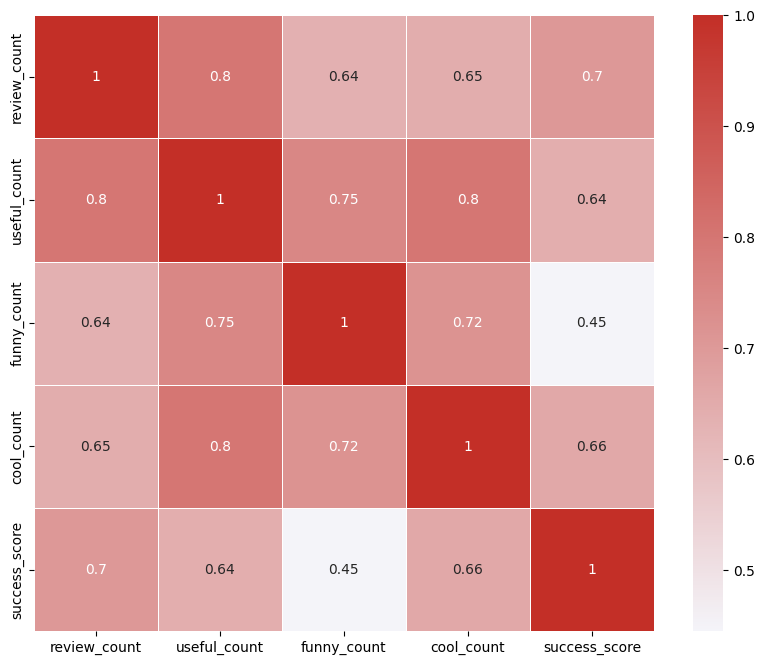

In [38]:
custom_cmap = LinearSegmentedColormap.from_list('red_to_grey', ['#f4f4f9', '#c32f27'])

plt.figure(figsize = (10,8))
sns.heatmap(corr1, cmap= custom_cmap, annot= True, linewidths= 0.5, linecolor= 'white', )
plt.show()

**Insights:** Review engagement (review count, useful, cool, funny) **positively correlates** with restaurant success, with review count, userful and cool reactions having the strongest** impact, while funny reactions have the least influence.

### User's (Elite vs non-Elite) influence on success

In [39]:
# Is there any difference in engagement of Elite users and non-elite users?

query = '''
            SELECT elite, COUNT(*) AS num_users, SUM(review_count) AS total_review_count
            FROM ( SELECT CASE WHEN elite = '' THEN 'Not Elite'
                            ELSE 'Elite' END AS elite, review_count
                    FROM user) AS user_elite
            GROUP BY elite;

            '''
elite_df = pd.read_sql(query, conn)
elite_df

,elite,num_users,total_review_count
0,Elite,91198,20484441
1,Not Elite,1896699,26021235


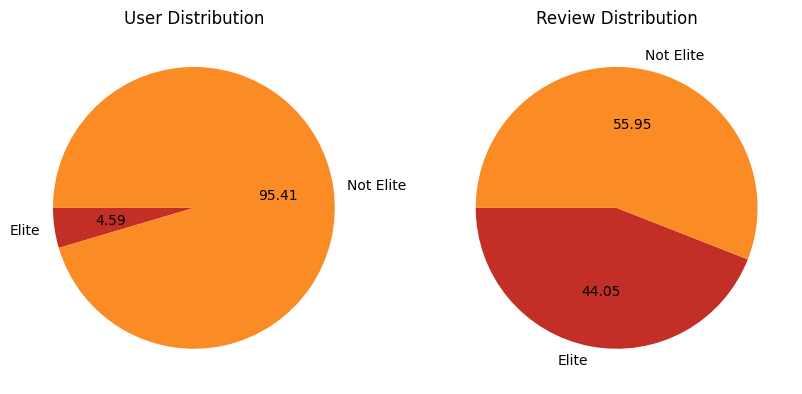

In [40]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.title('User Distribution')
plt.pie(elite_df['num_users'], labels= elite_df['elite'], autopct='%.2f', startangle= 180, colors= ['#c32f27', '#fa8b25'])

plt.subplot(1,2,2)
plt.title('Review Distribution')
plt.pie(elite_df['total_review_count'], labels= elite_df['elite'], autopct='%.2f', startangle= 180, colors= ['#c32f27', '#fa8b25'])

plt.show()

**Insight:** </br>
Elite users are a very small group (~4.6% of users) but contribute **nearly as many reviews** as non-elite users, indicating that **elite users are significantly more active and engaged** on the platform compared to regular users.


### Restaurant's busiest hours

In [41]:
# What are the busiest hours for restaurants?
query = ''' SELECT CAST(strftime('%H', date) AS integer) AS hour, COUNT(*) AS review_count
            FROM review
            GROUP BY hour;
            '''
review_engagement = pd.read_sql(query, conn)

query = ''' SELECT CAST(strftime('%H', date) AS integer) AS hour, COUNT(*) AS tip_count
            FROM tip
            GROUP BY hour;
            '''
tip_engagement = pd.read_sql(query, conn)

checkin = pd.read_sql('SELECT date FROM checkin', conn)
checkin_engagement = []

for i in checkin['date']:
    checkin_engagement.extend([datetime.strptime(j.strip(),"%Y-%m-%d %H:%M:%S").strftime("%H") for j in i.split(',')])

checkin_engagement = pd.DataFrame(checkin_engagement).astype('int').groupby(0)[[0]].count()

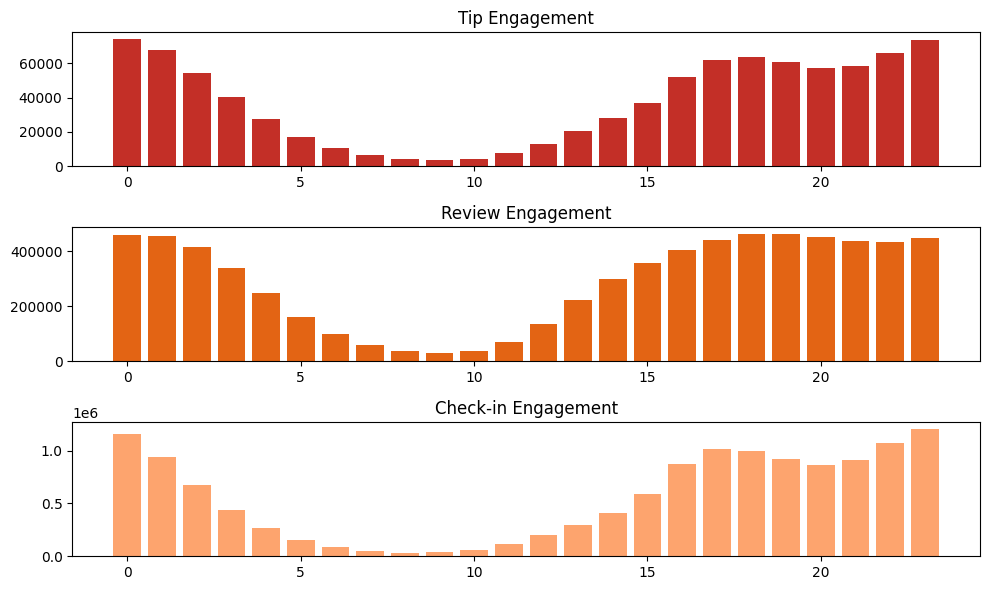

In [42]:
plt.figure(figsize = (10,6))

plt.subplot(3,1,1)
plt.title('Tip Engagement')
plt.bar(tip_engagement['hour'], tip_engagement['tip_count'], color = '#c32f27')

plt.subplot(3,1,2)
plt.title('Review Engagement')
plt.bar(review_engagement['hour'], review_engagement['review_count'], color = '#e36414')

plt.subplot(3,1,3)
plt.title('Check-in Engagement')
plt.bar(checkin_engagement.index, checkin_engagement[0], color = '#fda46e')

plt.tight_layout()
plt.show()

**Insights:** Engagement data (reviews, tips, check-ins) shows restaurants are **busiest between 5 PM and 1 AM**, making evening and late-night operations a critical success factor.

## Conclusion

- A small group of elite users (4.6%) generates nearly half of all reviews, showing their outsized impact on platform engagement.
- Restaurant activity peaks between 5 PM and 1 AM, making evening and late-night hours a key success factor.
- Review engagement metrics (review count, useful, cool) show the strongest positive correlation with success, while funny reactions have minimal influence.
- Seasonality effects are evident, with engagement peaking at the beginning and end of the year.
- User engagement increases with ratings, peaking at 4.0–4.5 stars, indicating that highly rated (but not perfect) restaurants attract the most interactions.